In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import math
import pandas as pd
import scipy.stats as sc
import random

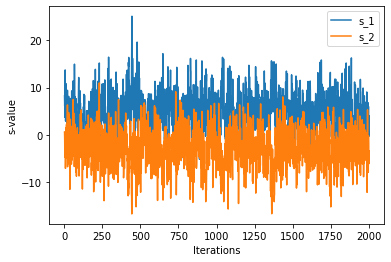

Time taken = 0.9200305938720703


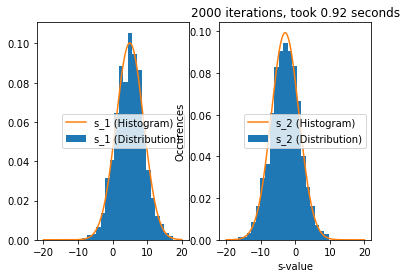

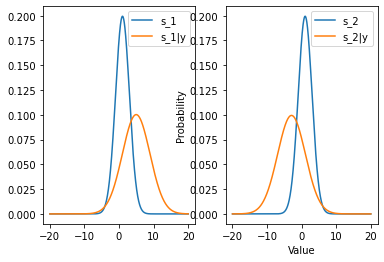

In [53]:
# Q5

def s_to_t(s1, s2, std_t): #Function to get t|s1,s2,y with s1, s2 as given values
    return truncnorm.rvs(0 - (s1-s2)/std_t, (np.inf - (s1-s2)/std_t), loc = (s1-s2), scale = std_t)

def t_to_s(t, mu_s_vector, std_s_matrix, A): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

def normal_dist(mu, sig, t):
    return (1/np.sqrt(2*np.pi*sig))*np.exp(-((t-mu)**2)/(2*sig))


#Timer
time_taken = time.time()

#Starting µ and σ for S
mu_s = 1
std_s = 4
x_distri = np.linspace(-20,20,10000)
s1_dist = normal_dist(mu_s, std_s, x_distri)
s2_dist = normal_dist(mu_s, std_s, x_distri)
#The start is a ROW since it is an input to a function that generates 2d normal distributions
# The vector is a COLUMN since it is used in calculations as was done in Q3
mu_s_start = np.array([mu_s, mu_s])
mu_s_vector = np.array([[mu_s], [mu_s]])
std_s_matrix = np.array([[std_s**2, 0], [0, std_s**2]])
std_s_start = np.array([[std_s**2, 0], [0, std_s**2]])
A = np.array([[1, -1]]) # A-vector in the calculations
std_t = 5 # σ for t

Iters = 2000 #iterations
ab = 3 # burnout period
All_S = np.zeros((Iters, 2)) #Containing drawn S values
All_t = np.zeros(Iters) #Containing drawn t values

# Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
All_S[0] = [np.random.normal(loc=mu_s, scale = std_s), np.random.normal(loc=mu_s, scale = std_s)]

# We calculate t, then s, and repeat for as many times as the iterations
for i in range(Iters-1):
    All_t[i] = s_to_t(All_S[i,0], All_S[i,1], std_t)
    All_S[i+1] = t_to_s(All_t[i], mu_s_vector, std_s_matrix, A)

# Result vectors, x stores iterations, y stores s1 and s2, w stores µ1 and µ2
x = [i for i in range(ab,Iters)]
y1 = [All_S[i][0] for i in range(ab,Iters)]
y2 = [All_S[i][1] for i in range(ab,Iters)]


# How s changes (after burnout period)
plt.plot(x,y1)
plt.plot(x,y2)
plt.legend(["s_1", "s_2"])
plt.xlabel("Iterations")
plt.ylabel("s-value")
plt.show()

#FINDING NEW MEAN AND CO VARIANCE FROM DRAWN S1 AND S2 FOR POSTERIOR DISTRIBUTION

#Finding mean
mu_S1 = np.mean(y1)
mu_S2 = np.mean(y2)

#Finding the Covariance matrix
co_11 = 0
co_121 = 0
co_22 = 0

for i in range(len(y1)):
    co_11 += (y1[i]-mu_S1)**2
    co_22 += (y2[i]-mu_S2)**2
    co_121 += (y1[i]-mu_S1)*(y2[i]-mu_S2)

co_11 /= len(y1)-1
co_121 /= len(y1)-1
co_22 /= len(y2)-1

# Putting the results into a vector (µ) and a matrix (covariance)
mu_vector = np.array([mu_S1, mu_S2])
covariance_matrix = np.array([[co_11, co_121], [co_121, co_22]])


s1_ny_dist = normal_dist(mu_S1, co_11, x_distri)
s2_ny_dist = normal_dist(mu_S2, co_22, x_distri)

# Samples excluding the burnout period
samples_drawn = Iters - ab

# Draws samples from the original µ values and covariance matrix, the draws values from the new M values and covariance matrix
All_samples_drawn = np.zeros((samples_drawn, 2))
Samples_from_start = np.zeros((samples_drawn, 2))
for i in range(samples_drawn):
    All_samples_drawn[i] = np.random.multivariate_normal(mu_vector, covariance_matrix)
    Samples_from_start[i] = np.random.multivariate_normal(mu_s_start, std_s_start)

#Results are split into new s1, s2 and starting value for s1, s2
newy1 = [All_samples_drawn[i][0] for i in range(samples_drawn)]
newy2 = [All_samples_drawn[i][1] for i in range(samples_drawn)]

#start1 = [Samples_from_start[i][0] for i in range(samples_drawn)]
#start2 = [Samples_from_start[i][1] for i in range(samples_drawn)]

#Timer stops, for accurate time comment out all the plots
time_taken = time.time() - time_taken
print(f"Time taken = {time_taken}")

#Shows the new distribution
figure, axis = plt.subplots(1,2)
axis[0].hist(newy1, density=1, bins=20)
axis[0].plot(x_distri, s1_ny_dist)
axis[0].legend(["s_1 (Histogram)", "s_1 (Distribution)"])

axis[1].hist(newy2, density=1, bins=20)
axis[1].plot(x_distri, s2_ny_dist)
axis[1].legend(["s_2 (Histogram)", "s_2 (Distribution)"])

plt.xlabel("s-value")
plt.ylabel("Occurences")
plt.title(f"{Iters} iterations, took {round(time_taken, 2)} seconds")

plt.show()

#shows the start distribution (s1, s2) and the resulting distribution (s1, s2|y)
figure, axis = plt.subplots(1,2)
axis[0].plot(x_distri, s1_dist)
axis[0].plot(x_distri, s1_ny_dist)
axis[0].legend(['s_1', 's_1|y'])

axis[1].plot(x_distri, s2_dist)
axis[1].plot(x_distri, s2_ny_dist)
axis[1].legend(['s_2', 's_2|y'])

plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In [54]:
# Q6
#Class for every team, showing µ, σ and team name
class team:
    def __init__(self, mu, var, name, skill):
        self.mu = mu
        self.var = var
        self.name = name
        self.skill = skill

def s_to_t(s1, s2, std_t, score): #Function to get t|s1,s2,y with s1, s2 as given values
    if score == -1:
        minval, maxval = -np.inf, 0
    else:
        minval, maxval = 0, np.inf
    return truncnorm.rvs(minval - (s1-s2)/std_t, (maxval - (s1-s2)/std_t), loc = (s1-s2), scale = std_t)

def t_to_s(t, A, std_t, std_s_matrix, mu_s_vector): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

std_t = 5 # starting σ for t

#Reads the data, the path has to be changed depending on where your target folder is in vs code, here the target folder is AML
input_data = pd.read_csv("SerieA.csv")

#Creates list of names
team_list = []
for teams in input_data["team1"]:
    if teams not in team_list:
        team_list.append(teams)

for teams in input_data["team2"]:
    if teams not in team_list:
        team_list.append(teams)

#Creates a list with all the teams (i.e. a list of classes)
team_data = []
for i in team_list:
    team_data.append(team(1,4,i,0))

Iters = 1000 #Iterations
ab = 20 #After burnout
A = np.array([[1, -1]]) # A-vector in the calculations

#Main loop
nr_matches = len(input_data["team1"])
for iteration in range(nr_matches):
    print(f"Calculating match {iteration} of {nr_matches}")
    i = iteration # Doing matches in sequence
    #i = nr_matches-1-iteration # doing matches in reverse
    #Get the score, if score is 0, the match is ignored
    score = input_data["score1"][i] - input_data["score2"][i]
    if score == 0:
        continue

    #Only the sign of the score is used
    score = np.sign(score)

    #Get the correct team data by fetching the names and then using the classes corresponding to those names
    team_1_name = input_data["team1"][i]
    team_2_name = input_data["team2"][i]

    for j in range(len(team_data)):
        if team_data[j].name == team_1_name:
            team1 = team_data[j]
        if team_data[j].name == team_2_name:
            team2 = team_data[j]
            
    #Set up µ-vector and covariance matrix
    mu_s_vector = np.array([[team1.mu], [team2.mu]])
    std_s_matrix = np.array([[team1.var**2, 0], [0, team2.var**2]])

    All_S = np.zeros((Iters, 2)) #Containing drawn S values
    All_t = np.zeros(Iters) #Containing drawn t values

    # Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
    All_S[0] = [np.random.normal(loc=team1.mu, scale = team1.var), np.random.normal(loc=team2.mu, scale = team2.var)]

    # We calculate t, then s, and repeat for as many times as the iterations
    for j in range(Iters-1):
        All_t[j] = s_to_t(All_S[j,0], All_S[j,1], std_t, score)
        All_S[j+1] = t_to_s(All_t[j], A, std_t, std_s_matrix, mu_s_vector)

    #Getting s1 and s2 values
    y1 = [All_S[j][0] for j in range(ab,Iters)]
    y2 = [All_S[j][1] for j in range(ab,Iters)]

    #Getting µ and σ
    mu_team1 = np.mean(y1)
    mu_team2 = np.mean(y2)
    var_team1 = 0
    var_team2 = 0
    for j in range(len(y1)):
        var_team1 += (y1[j]-mu_team1)**2
        var_team2 += (y2[j]-mu_team2)**2
    var_team1 /= len(y1)-1
    var_team2 /= len(y1)-1
    var_team1 = math.sqrt(var_team1)
    var_team2 = math.sqrt(var_team2)
    team1.mu = mu_team1
    team2.mu = mu_team2
    team1.var = var_team1
    team2.var = var_team2

#Drawing 100 random numbers from the distributions to determine skill
for current_team in team_data:
    for i in range(100):
        partial_skill = np.random.normal(loc=current_team.mu, scale = current_team.var)/100
        current_team.skill += partial_skill

team_data.sort(key=lambda team: team.skill, reverse=True)

print("TEAM SKILLS AND RANKINGS:")
for i in range(len(team_data)):
    print(f"{i+1}. {team_data[i].name}: Skill = {round(team_data[i].skill, 2)}, µ = {round(team_data[i].mu, 2)}, sig = {round(team_data[i].var, 2)}")

Calculating match 0 of 380
Calculating match 1 of 380
Calculating match 2 of 380
Calculating match 3 of 380
Calculating match 4 of 380
Calculating match 5 of 380
Calculating match 6 of 380
Calculating match 7 of 380
Calculating match 8 of 380
Calculating match 9 of 380
Calculating match 10 of 380
Calculating match 11 of 380
Calculating match 12 of 380
Calculating match 13 of 380
Calculating match 14 of 380
Calculating match 15 of 380
Calculating match 16 of 380
Calculating match 17 of 380
Calculating match 18 of 380
Calculating match 19 of 380
Calculating match 20 of 380
Calculating match 21 of 380
Calculating match 22 of 380
Calculating match 23 of 380
Calculating match 24 of 380
Calculating match 25 of 380
Calculating match 26 of 380
Calculating match 27 of 380
Calculating match 28 of 380
Calculating match 29 of 380
Calculating match 30 of 380
Calculating match 31 of 380
Calculating match 32 of 380
Calculating match 33 of 380
Calculating match 34 of 380
Calculating match 35 of 380
Ca

In [55]:
# Q7
def prediction(mu1, mu2, std1, std2, y, N):
    #will try to predict N simulations of given match and return how many are correct
    t=np.zeros(N)
    mut=np.random.normal(mu1,std1,N)-np.random.normal(mu2,std2,N)
    for i in range(N):
        t[i]=np.random.normal(mut[i],5)
    accuracy=sum(y==np.sign(t))/N
    return accuracy


def prediction_rate(result, team1, team2, n_games, teams_data):
    
    #makes directionary of the team class.names and gives them a number for easier use
    teams = {}
    for j in range(len(team_data)): 
        teams[team_data[j].name]=j
        
    y=np.sign(result)
    accuracy, total_games = 0, 0 

    # Loop over all games
    for game in range(n_games):
        print(f"{game} of {n_games}: {(game/n_games*100):.2f}%")

        if y[game] != 0:  #no ties allowed
            # Get mean and variance of the teams
            home_team = team1[game]
            away_team = team2[game]
            std1 = teams_data[teams[home_team]].var
            std2 = teams_data[teams[away_team]].var
            mu1 = teams_data[teams[home_team]].mu
            mu2 = teams_data[teams[away_team]].mu
            
            # Calculate the amount of correct guesses of result
            total_games = total_games + 1
            accuracy += prediction(mu1, mu2, std1, std2, y[game], 1000) #use prediction function

    
    return accuracy/total_games # return r



def main(input_data, teams_data):

        #all usefull data from the result of
    team1 = input_data["team1"] #list of team ones
    team2 = input_data["team2"] #list of team twos
    results = input_data["score1"]-input_data["score2"] #score difference each match
    n_games = len(np.array(team1))  # number of games

    # Original order of games
    prediction_rate_original = prediction_rate(results, team1, team2, n_games, teams_data)


    print(f"Prediction Rate with orginal order of games: r={prediction_rate_original:.5f}")


main(input_data, team_data)

0 of 380: 0.00%
1 of 380: 0.26%
2 of 380: 0.53%
3 of 380: 0.79%
4 of 380: 1.05%
5 of 380: 1.32%
6 of 380: 1.58%
7 of 380: 1.84%
8 of 380: 2.11%
9 of 380: 2.37%
10 of 380: 2.63%
11 of 380: 2.89%
12 of 380: 3.16%
13 of 380: 3.42%
14 of 380: 3.68%
15 of 380: 3.95%
16 of 380: 4.21%
17 of 380: 4.47%
18 of 380: 4.74%
19 of 380: 5.00%
20 of 380: 5.26%
21 of 380: 5.53%
22 of 380: 5.79%
23 of 380: 6.05%
24 of 380: 6.32%
25 of 380: 6.58%
26 of 380: 6.84%
27 of 380: 7.11%
28 of 380: 7.37%
29 of 380: 7.63%
30 of 380: 7.89%
31 of 380: 8.16%
32 of 380: 8.42%
33 of 380: 8.68%
34 of 380: 8.95%
35 of 380: 9.21%
36 of 380: 9.47%
37 of 380: 9.74%
38 of 380: 10.00%
39 of 380: 10.26%
40 of 380: 10.53%
41 of 380: 10.79%
42 of 380: 11.05%
43 of 380: 11.32%
44 of 380: 11.58%
45 of 380: 11.84%
46 of 380: 12.11%
47 of 380: 12.37%
48 of 380: 12.63%
49 of 380: 12.89%
50 of 380: 13.16%
51 of 380: 13.42%
52 of 380: 13.68%
53 of 380: 13.95%
54 of 380: 14.21%
55 of 380: 14.47%
56 of 380: 14.74%
57 of 380: 15.00%
58 o

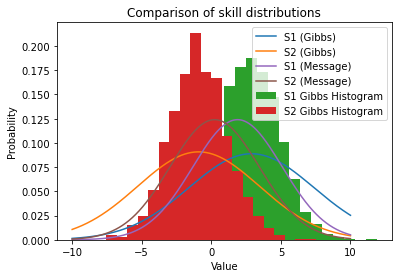

mean_fct = 0
var_fct = 13
mean_q = 2.876813695875796
var_q = 4.723942959221441
mean_tfc = 4.51888838635495
var_tfc = 7.420352248333652
mean_fcs1 = 5.51888838635495
var_fcs1 = 16.42035224833365
mean_s1Iy = 1.8851734448848605
var_s1Iy = 3.216467972470669
mean_fcs2 = -2.9014638619787014
var_fcs2 = 16.42035224833365
mean_s2Iy = 0.2357695274728534
var_s2Iy = 3.216467972470669


In [56]:
# Q9
def s_to_t(s1, s2, std_t): #Function to get t|s1,s2,y with s1, s2 as given values
    return truncnorm.rvs(0 - (s1-s2)/std_t, (np.inf - (s1-s2)/std_t), loc = (s1-s2), scale = std_t)

def t_to_s(t, mu_s_vector, std_s_matrix, A, std_t): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

def main():
    # initial
    mean_1 = 1
    var_1 = 4
    mean_2 = 1
    var_2 = 4
    beta = 5
    y = 1

    mu_s_vector = np.array([[mean_1], [mean_2]])
    std_s_matrix = np.array([[var_1, 0], [0, var_2]])
    A = np.array([[1, -1]]) # A-vector in the calculations

    Iters = 2000 #iterations
    ab = 30 # burnout period

    All_S = np.zeros((Iters, 2)) #Containing drawn S values
    All_t = np.zeros(Iters) #Containing drawn t values

    # Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
    All_S[0] = [np.random.normal(loc=mean_1, scale = var_1), np.random.normal(loc=mean_2, scale = var_2)]

    # We calculate t, then s, and repeat for as many times as the iterations
    for i in range(Iters-1):
        All_t[i] = s_to_t(All_S[i,0], All_S[i,1], beta)
        All_S[i+1] = t_to_s(All_t[i], mu_s_vector, std_s_matrix, A, beta)

    # Result vectors, x stores iterations, y stores s1 and s2, w stores µ1 and µ2
    x = [i for i in range(ab,Iters)]
    y1 = [All_S[i][0] for i in range(ab,Iters)]
    y2 = [All_S[i][1] for i in range(ab,Iters)]
    #Finding mean
    mu_S1 = np.mean(y1)
    mu_S2 = np.mean(y2)

    #Finding the Covariance matrix
    co_11 = 0
    co_121 = 0
    co_22 = 0

    for i in range(len(y1)):
        co_11 += (y1[i]-mu_S1)**2
        co_22 += (y2[i]-mu_S2)**2
        co_121 += (y1[i]-mu_S1)*(y2[i]-mu_S2)

    co_11 /= len(y1)-1
    co_121 /= len(y1)-1
    co_22 /= len(y2)-1
    samples_drawn = Iters - ab

    # Putting the results into a vector (µ) and a matrix (covariance)
    mu_vector = np.array([mu_S1, mu_S2])
    covariance_matrix = np.array([[co_11, co_121], [co_121, co_22]])
    # Draws samples from the original µ values and covariance matrix, the draws values from the new M values and covariance matrix
    All_samples_drawn = np.zeros((samples_drawn, 2))
    for i in range(samples_drawn):
        All_samples_drawn[i] = np.random.multivariate_normal(mu_vector, covariance_matrix)

    #Results are split into new s1, s2 and starting value for s1, s2
    newy1 = [All_samples_drawn[i][0] for i in range(samples_drawn)]
    newy2 = [All_samples_drawn[i][1] for i in range(samples_drawn)]

    # fc to t
    mean_fct = mean_1 - mean_2 #(np.array([1, -1])@np.array([[mean_1], [mean_2]]))[0]
    var_fct = beta + var_1 + var_2 #beta + np.array([1, -1])@np.array([[var_1, 0], [0, var_2]])@np.array([1, -1]).T

    # fd to t
    if y == 1:
        a, b = 0, 1000
    else:
        a, b = -1000, 0

    # q(t) approximation of p(t|y)
    a = (a - mean_fct)/np.sqrt(var_fct)
    b = (b - mean_fct)/np.sqrt(var_fct)
    mean_q = truncnorm.mean(a, b, loc=mean_fct, scale=np.sqrt(var_fct))
    var_q = truncnorm.var(a, b, loc=mean_fct, scale=np.sqrt(var_fct))

    # message passing algorithm

    # t to fc
    mean_tfc = (mean_q*var_fct - mean_fct*var_q)/(var_fct - var_q)
    var_tfc = (var_q*var_fct)/(var_fct - var_q)

    # fc to s1
    mean_fcs1 = mean_tfc + mean_2 #(np.array([1, 1])@np.array([[mean_tfc], [mean_2]]))[0]
    var_fcs1 = beta + var_tfc + var_2 #beta + np.array([1, 1])@np.array([[var_tfc, 0],[0, var_2]])@np.array([1, 1]).T

    # p(s1|y)
    mean_s1Iy = (mean_fcs1*var_1 + mean_1*var_fcs1)/(var_fcs1 + var_1)
    var_s1Iy = (var_fcs1*var_1)/(var_1 + var_fcs1) 

    # fc to s2
    mean_fcs2 = (np.array([1, -1])@np.array([[mean_tfc], [var_tfc]]))[0]
    var_fcs2 = beta + np.array([1, -1])@np.array([[var_tfc, 0], [0, var_1]])@np.array([1, -1]).T

    # p(s2|y)
    mean_s2Iy = (mean_fcs2*var_2 + mean_2*var_fcs2)/(var_fcs2 + var_2)
    var_s2Iy = var_fcs2*var_2/(var_2 + var_fcs2)

    # plot

    # posteriors
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, sc.norm.pdf(x, mu_S1, co_11))
    plt.plot(x, sc.norm.pdf(x, mu_S2, co_22))
    plt.hist(newy1, density=1, bins=20)
    plt.hist(newy2, density=1, bins=20)
    plt.plot(x, sc.norm.pdf(x, mean_s1Iy, var_s1Iy))
    plt.plot(x, sc.norm.pdf(x, mean_s2Iy, var_s2Iy))
    plt.legend(["S1 (Gibbs)", "S2 (Gibbs)", "S1 (Message)", "S2 (Message)","S1 Gibbs Histogram", "S2 Gibbs Histogram"])
    plt.xlabel("Value")
    plt.ylabel("Probability")
    plt.title("Comparison of skill distributions")
    plt.show()
    

   
    print(f'mean_fct = {mean_fct}')
    print(f'var_fct = {var_fct}')
    print(f'mean_q = {mean_q}')
    print(f'var_q = {var_q}')
    print(f'mean_tfc = {mean_tfc}')
    print(f'var_tfc = {var_tfc}')
    print(f'mean_fcs1 = {mean_fcs1}')
    print(f'var_fcs1 = {var_fcs1}')
    print(f'mean_s1Iy = {mean_s1Iy}')
    print(f'var_s1Iy = {var_s1Iy}')
    print(f'mean_fcs2 = {mean_fcs2}')
    print(f'var_fcs2 = {var_fcs2}')
    print(f'mean_s2Iy = {mean_s2Iy}')
    print(f'var_s2Iy = {var_s2Iy}')
    




if __name__ == '__main__':
    main()

In [57]:
# Q10
#Class for every team, showing µ, σ and team name
class team:
    def __init__(self, mu, var, name, skill):
        self.mu = mu
        self.var = var
        self.name = name
        self.skill = skill

def s_to_t(s1, s2, std_t, score): #Function to get t|s1,s2,y with s1, s2 as given values
    score=np.sign(score)
    if score == -1:
        minval, maxval = -np.inf, 0
    else:
        minval, maxval = 0, np.inf
    return truncnorm.rvs(minval - (s1-s2)/std_t, (maxval - (s1-s2)/std_t), loc = (s1-s2), scale = std_t)

def t_to_s(t, A, std_t,std_s_matrix, mu_s_vector): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

std_t = 5 # starting σ for t

#Reads the data, the path has to be changed depending on where your target folder is in vs code, here the target folder is AML
input_data = pd.read_csv("res_fence_short.csv")

input_data

#Creates list of names
team_list = []
for teams in input_data["ID1"]:
    if teams not in team_list:
        team_list.append(teams)

for teams in input_data["ID2"]:
    if teams not in team_list:
        team_list.append(teams)

#Creates a list with all the teams (i.e. a list of classes)
team_data = []
for i in team_list:
    team_data.append(team(1,4,i,0))

Iters = 1000 #Iterations
ab = 20 #After burnout
A = np.array([[1, -1]]) # A-vector in the calculations

#Main loop
nr_matches = len(input_data["ID1"])
for iteration in range(nr_matches):
    print(f"Calculating match {iteration+1} of {nr_matches}")
    i = iteration # Doing matches in sequence
    #i = nr_matches-1-iteration # doing matches in reverse
    #Get the score, if score is 0, the match is ignored
    score = input_data["PD"][i]
    if score == 0:
        continue

    #Only the sign of the score is used
    score = int(score)
    true_score = score
    score = np.sign(score)

    #Get the correct team data by fetching the names and then using the classes corresponding to those names
    team_1_name = input_data["ID1"][i]
    team_2_name = input_data["ID2"][i]

    for j in range(len(team_data)):
        if team_data[j].name == team_1_name:
            team1 = team_data[j]
        if team_data[j].name == team_2_name:
            team2 = team_data[j]
    

    #Set up µ-vector and covariance matrix
    mu_s_vector = np.array([[team1.mu], [team2.mu]])
    std_s_matrix = np.array([[team1.var**2, 0], [0, team2.var**2]])

    All_S = np.zeros((Iters, 2)) #Containing drawn S values
    All_t = np.zeros(Iters) #Containing drawn t values

    # Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
    All_S[0] = [np.random.normal(loc=team1.mu, scale = team1.var), np.random.normal(loc=team2.mu, scale = team2.var)]

    # We calculate t, then s, and repeat for as many times as the iterations
    for j in range(Iters-1):
        All_t[j] = s_to_t(All_S[j,0], All_S[j,1], std_t, score)
        All_S[j+1] = t_to_s(All_t[j], A, std_t,std_s_matrix, mu_s_vector)

    #Getting s1 and s2 values
    y1 = [All_S[j][0] for j in range(ab,Iters)]
    y2 = [All_S[j][1] for j in range(ab,Iters)]

    #Getting µ and σ
    mu_team1 = np.mean(y1)
    mu_team2 = np.mean(y2)
    var_team1 = 0
    var_team2 = 0
    for j in range(len(y1)):
        var_team1 += (y1[j]-mu_team1)**2
        var_team2 += (y2[j]-mu_team2)**2
    var_team1 /= len(y1)-1
    var_team2 /= len(y1)-1
    var_team1 = math.sqrt(var_team1)
    var_team2 = math.sqrt(var_team2)
    team1.mu = mu_team1
    team2.mu = mu_team2
    team1.var = var_team1
    team2.var = var_team2

#Drawing 100 random numbers from the distributions to determine skill
for current_team in team_data:
    for i in range(100):
        partial_skill = np.random.normal(loc=current_team.mu, scale = current_team.var)/100
        current_team.skill += partial_skill

team_data.sort(key=lambda team: team.skill, reverse=True)

print("TEAM SKILLS AND RANKINGS:")
for i in range(len(team_data)):
    print(f"{i+1}. {team_data[i].name}: Skill = {round(team_data[i].skill, 2)}, µ = {round(team_data[i].mu, 2)}, sig = {round(team_data[i].var, 2)}")

Calculating match 1 of 130
Calculating match 2 of 130
Calculating match 3 of 130
Calculating match 4 of 130
Calculating match 5 of 130
Calculating match 6 of 130
Calculating match 7 of 130
Calculating match 8 of 130
Calculating match 9 of 130
Calculating match 10 of 130
Calculating match 11 of 130
Calculating match 12 of 130
Calculating match 13 of 130
Calculating match 14 of 130
Calculating match 15 of 130
Calculating match 16 of 130
Calculating match 17 of 130
Calculating match 18 of 130
Calculating match 19 of 130
Calculating match 20 of 130
Calculating match 21 of 130
Calculating match 22 of 130
Calculating match 23 of 130
Calculating match 24 of 130
Calculating match 25 of 130
Calculating match 26 of 130
Calculating match 27 of 130
Calculating match 28 of 130
Calculating match 29 of 130


KeyboardInterrupt: 

In [58]:
# Q11

#Class for every team, showing µ, σ and team name
class team:
    def __init__(self, mu, var, name, skill):
        self.mu = mu
        self.var = var
        self.name = name
        self.skill = skill

def s_to_t(s1, s2, std_t, true_score): #Function to get t|s1,s2,y with s1, s2 as given values
    score=np.sign(true_score)
    if score == -1:
        minval, maxval = -np.inf, 0
    else:
        minval, maxval = 0, np.inf
    # adding true_score/2 to shift the truncnorm
    return truncnorm.rvs(minval - (s1-s2)/std_t+true_score/2, (maxval - (s1-s2)/std_t)+true_score/2, loc = (s1-s2), scale = std_t)

def t_to_s(t, A, std_t,std_s_matrix, mu_s_vector): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

std_t = 5 # starting σ for t

#Reads the data, the path has to be changed depending on where your target folder is in vs code, here the target folder is AML
input_data = pd.read_csv("res_fence_short.csv")

input_data

#Creates list of names
team_list = []
for teams in input_data["ID1"]:
    if teams not in team_list:
        team_list.append(teams)

for teams in input_data["ID2"]:
    if teams not in team_list:
        team_list.append(teams)

#Creates a list with all the teams (i.e. a list of classes)
team_data = []
for i in team_list:
    team_data.append(team(1,4,i,0))

Iters = 1000 #Iterations
ab = 20 #After burnout
A = np.array([[1, -1]]) # A-vector in the calculations

#Main loop
nr_matches = len(input_data["ID1"])
for iteration in range(nr_matches):
    print(f"Calculating match {iteration+1} of {nr_matches}")
    i = iteration # Doing matches in sequence
    #i = nr_matches-1-iteration # doing matches in reverse
    #Get the score, if score is 0, the match is ignored
    score = input_data["PD"][i]
    if score == 0:
        continue

    #Only the sign of the score is used
    score = int(score)
    true_score = score
    score = np.sign(score)

    #Get the correct team data by fetching the names and then using the classes corresponding to those names
    team_1_name = input_data["ID1"][i]
    team_2_name = input_data["ID2"][i]

    for j in range(len(team_data)):
        if team_data[j].name == team_1_name:
            team1 = team_data[j]
        if team_data[j].name == team_2_name:
            team2 = team_data[j]
    
    skill_dif = team1.name - team2.name
    skill_sign = np.sign(skill_dif)
    

    #Set up µ-vector and covariance matrix
    mu_s_vector = np.array([[team1.mu], [team2.mu]])
    std_s_matrix = np.array([[team1.var**2, 0], [0, team2.var**2]])

    All_S = np.zeros((Iters, 2)) #Containing drawn S values
    All_t = np.zeros(Iters) #Containing drawn t values

    # Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
    All_S[0] = [np.random.normal(loc=team1.mu, scale = team1.var), np.random.normal(loc=team2.mu, scale = team2.var)]

    # We calculate t, then s, and repeat for as many times as the iterations
    for j in range(Iters-1):
        All_t[j] = s_to_t(All_S[j,0], All_S[j,1], std_t, true_score)
        All_S[j+1] = t_to_s(All_t[j], A, std_t,std_s_matrix, mu_s_vector)

    #Getting s1 and s2 values
    y1 = [All_S[j][0] for j in range(ab,Iters)]
    y2 = [All_S[j][1] for j in range(ab,Iters)]

    #Getting µ and σ
    mu_team1 = np.mean(y1)
    mu_team2 = np.mean(y2)
    var_team1 = 0
    var_team2 = 0
    for j in range(len(y1)):
        var_team1 += (y1[j]-mu_team1)**2
        var_team2 += (y2[j]-mu_team2)**2
    var_team1 /= len(y1)-1
    var_team2 /= len(y1)-1
    var_team1 = math.sqrt(var_team1)
    var_team2 = math.sqrt(var_team2)
    team1.mu = mu_team1
    team2.mu = mu_team2
    team1.var = var_team1
    team2.var = var_team2

#Drawing 100 random numbers from the distributions to determine skill
for current_team in team_data:
    for i in range(100):
        partial_skill = np.random.normal(loc=current_team.mu, scale = current_team.var)/100
        current_team.skill += partial_skill

team_data.sort(key=lambda team: team.skill, reverse=True)

print("TEAM SKILLS AND RANKINGS:")
for i in range(len(team_data)):
    print(f"{i+1}. {team_data[i].name}: {round(team_data[i].skill, 2)}")

Calculating match 1 of 130
Calculating match 2 of 130
Calculating match 3 of 130
Calculating match 4 of 130
Calculating match 5 of 130
Calculating match 6 of 130
Calculating match 7 of 130
Calculating match 8 of 130
Calculating match 9 of 130
Calculating match 10 of 130
Calculating match 11 of 130
Calculating match 12 of 130
Calculating match 13 of 130
Calculating match 14 of 130
Calculating match 15 of 130
Calculating match 16 of 130
Calculating match 17 of 130
Calculating match 18 of 130
Calculating match 19 of 130
Calculating match 20 of 130


KeyboardInterrupt: 

In [46]:
#prediction for fencing
def prediction(mu1, mu2, std1, std2, y, N):
    #will try to predict N simulations of given match and return how many are correct
    t=np.zeros(N)
    mut=np.random.normal(mu1,std1,N)-np.random.normal(mu2,std2,N)
    for i in range(N):
        t[i]=np.random.normal(mut[i],5)
    accuracy=sum(y==np.sign(t))/N
    return accuracy


def prediction_rate(result, team1, team2, n_games, teams_data):
    
    #makes directionary of the team class.names and gives them a number for easier use
    teams = {}
    for j in range(len(team_data)): 
        teams[team_data[j].name]=j
        
    y=np.sign(result)
    accuracy, total_games = 0, 0 

    # Loop over all games
    for game in range(n_games):
        print(f"{game} of {n_games}: {(game/n_games*100):.2f}%")

        if y[game] != 0:  #no ties allowed
            # Get mean and variance of the teams
            home_team = team1[game]
            away_team = team2[game]
            std1 = teams_data[teams[home_team]].var
            std2 = teams_data[teams[away_team]].var
            mu1 = teams_data[teams[home_team]].mu
            mu2 = teams_data[teams[away_team]].mu
            
            # Calculate the amount of correct guesses of result
            total_games = total_games + 1
            accuracy += prediction(mu1, mu2, std1, std2, y[game], 1000) #use prediction function

    
    return accuracy/total_games # return r



def main(input_data, teams_data):

        #all usefull data from the result of
    team1 = input_data["ID1"] #list of team ones
    team2 = input_data["ID2"] #list of team twos
    results = input_data["PD"] #score difference each match
    n_games = len(np.array(team1))  # number of games

    # Original order of games
    prediction_rate_original = prediction_rate(results, team1, team2, n_games, teams_data)


    print(f"Prediction Rate with orginal order of games: r={prediction_rate_original:.5f}")


main(input_data, team_data)

0 of 130: 0.00%
1 of 130: 0.77%
2 of 130: 1.54%
3 of 130: 2.31%
4 of 130: 3.08%
5 of 130: 3.85%
6 of 130: 4.62%
7 of 130: 5.38%
8 of 130: 6.15%
9 of 130: 6.92%
10 of 130: 7.69%
11 of 130: 8.46%
12 of 130: 9.23%
13 of 130: 10.00%
14 of 130: 10.77%
15 of 130: 11.54%
16 of 130: 12.31%
17 of 130: 13.08%
18 of 130: 13.85%
19 of 130: 14.62%
20 of 130: 15.38%
21 of 130: 16.15%
22 of 130: 16.92%
23 of 130: 17.69%
24 of 130: 18.46%
25 of 130: 19.23%
26 of 130: 20.00%
27 of 130: 20.77%
28 of 130: 21.54%
29 of 130: 22.31%
30 of 130: 23.08%
31 of 130: 23.85%
32 of 130: 24.62%
33 of 130: 25.38%
34 of 130: 26.15%
35 of 130: 26.92%
36 of 130: 27.69%
37 of 130: 28.46%
38 of 130: 29.23%
39 of 130: 30.00%
40 of 130: 30.77%
41 of 130: 31.54%
42 of 130: 32.31%
43 of 130: 33.08%
44 of 130: 33.85%
45 of 130: 34.62%
46 of 130: 35.38%
47 of 130: 36.15%
48 of 130: 36.92%
49 of 130: 37.69%
50 of 130: 38.46%
51 of 130: 39.23%
52 of 130: 40.00%
53 of 130: 40.77%
54 of 130: 41.54%
55 of 130: 42.31%
56 of 130: 43.0